In [15]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw

# Function to extract fish data from Excel and match them to image files
def extract_fish_data(excel_path, images_folder):
    """
    Match fish data from Excel table with fish images in a folder. 
    Zip the Image Names (Data) with the Edema and Curved columns (Labels).
    
    Parameters:
        excel_path (str): Path to the Excel table with columns 'sample', 'fish', 'edema', 'curved'.
        images_folder (str): Path to the folder containing fish images.
        
    Returns:
        list: A list of tuples (image_filename, edema, curved).
    """
    # Load the Excel table
    data = pd.read_excel(excel_path)
    
    # Ensure columns are correctly named
    required_columns = {'Sample', 'Fish_Num', 'Edema', 'Curved'}
    if not required_columns.issubset(data.columns):
        raise ValueError(f"The Excel file must contain the following columns: {required_columns}")

    # Prepare the output list
    matched_data = []
    
    # Iterate through the Excel rows
    for _, row in data.iterrows():
        # Skip rows with 'NAW' in either 'edema' or 'curved'
        if row['Edema'] == "NAW" or row['Curved'] == "NAW":
            continue
        
        # Search for corresponding image file
        for image_file in os.listdir(images_folder):
            if f"pr_{str(row['Sample'])}" in image_file and f"-{str(row['Fish_Num']).zfill(2)}." in image_file:
                # Match found, append to result list
                matched_data.append((image_file, row['Edema'], row['Curved']))
                break  # Move to the next row in the Excel table

    return matched_data

# Function to create the binary mask from XML data
def parse_voc_polygon(xml_path, image_size):
    """Parse the XML to generate the binary mask from polygon annotations."""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Create an empty binary mask (0 means background, 1 means object)
    width, height = image_size
    mask = Image.new("1", (width, height), 0)

    draw = ImageDraw.Draw(mask)
    for obj in root.findall("object"):
        polygon = obj.find("polygon")
        if polygon is not None:
            points = []
            for i in range(1, 500):  # Assuming max 500 points in a polygon
                x_tag = f"x{i}"
                y_tag = f"y{i}"
                x = polygon.find(x_tag)
                y = polygon.find(y_tag)
                if x is not None and y is not None:
                    points.append((int(float(x.text)), int(float(y.text))))
                else:
                    break
            draw.polygon(points, outline=1, fill=1)

    return mask

# Function to create images and masks from the folder
def create_data_from_folder(folder_path):
    """
    Create lists of image and label arrays (binary masks) from a given folder.
    
    Args:
        folder_path (str): Path to the folder containing images and .xml files.
    
    Returns:
        tuple: Two lists, one for images (as numpy arrays) and one for labels (as numpy arrays).
    """
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]  # Adjusted to .jpg
    xml_files = []

    # Find corresponding XML files based on image filenames
    for image_file in image_files:
        # Get the base name of the image file (remove the ".jpg" part)
        base_name = image_file.replace('.jpg', '')

        # Find the corresponding XML file by using the base name
        xml_file = [f for f in os.listdir(folder_path) if base_name in f and f.endswith('.xml')]

        # If a corresponding XML file is found, add to xml_files list
        if xml_file:
            xml_files.append(xml_file[0])  # Assume there is only one corresponding XML file

    images = []
    labels = []

    # Process each image and its corresponding XML
    for image_file, xml_file in zip(image_files, xml_files):
        img_path = os.path.join(folder_path, image_file)
        xml_path = os.path.join(folder_path, xml_file)

        # Parse XML and create the binary mask (label)
        mask = parse_voc_polygon(xml_path, Image.open(img_path).size)

        # Append the image and mask (binary label) as numpy arrays
        image = np.array(Image.open(img_path).convert("RGB"))
        label = np.array(mask)

        images.append(image)
        labels.append(label)

    # Convert lists to numpy arrays
    images_np = np.array(images)
    labels_np = np.array(labels)
    
    return images_np, labels_np

# Function to create the final DataFrame combining Excel data with images and masks
def create_final_dataframe(excel_path, images_folder, data_folder):
    """
    Create a DataFrame combining image, mask, edema, and curved labels.
    
    Args:
        excel_path (str): Path to the Excel table with columns 'sample', 'fish', 'edema', 'curved'.
        images_folder (str): Path to the folder containing fish images.
        data_folder (str): Path to the folder containing images and .xml files for masks.
    
    Returns:
        pd.DataFrame: A DataFrame containing image, mask, edema, curved, and fish_body.
    """
    # Extract data from Excel file and match with image files
    matched_data = extract_fish_data(excel_path, images_folder)
    
    # Create image and label arrays from the XML files in the data folder
    images_np, labels_np = create_data_from_folder(data_folder)

    # Prepare the final data (image, mask, edema, curved, fish_body)
    final_data = []
    for (image_file, edema, curved), image, mask in zip(matched_data, images_np, labels_np):
        # Apply mask to image
        fish_body = image * np.expand_dims(mask, axis=-1)  # Apply the mask to the image

        final_data.append({
            'image': image,
            'mask': mask,
            'edema': edema,
            'curved': curved,
            'fish_body': fish_body  # Add the masked image
        })

    # Convert the final data to a DataFrame
    df = pd.DataFrame(final_data)
    
    return df

# Example usage
excel_path = "Annotation_Zebrafish.xlsx"
images_folder = "C:/Users/ma405l/Documents/Heidelberg_Schweregrad/Full_data/Raw_data_full_train"  # Path to folder with images for matching
data_folder = "C:/Users/ma405l/Documents/Heidelberg_Schweregrad/Full_data/Raw_data_full_train"  # Path to folder with images and XMLs for masks

# Create the final DataFrame
final_df = create_final_dataframe(excel_path, images_folder, data_folder)


In [16]:
import matplotlib.pyplot as plt
i=1
# Let's check the first image and its label
first_image = final_df['image'][i]
first_label = final_df['fish_body'][i]

# Display the first image and the corresponding first label map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display the image
ax1.imshow(first_image)
ax1.set_title("First Image")
ax1.axis('off')  # Hide axes

# Display the label map (binary mask)
ax2.imshow(first_label, cmap='gray')
ax2.set_title("First Label Map")
ax2.axis('off')  # Hide axes

plt.show()

KeyError: 'image'

In [ ]:
fish_body_processed = []

for fish_body in final_df["fish_body"]:
    # Convert the fish body to a numpy array if it's not already
    fish_body_array = np.array(fish_body)
    
    # Find the non-black rows and columns
    non_black_rows = np.any(fish_body_array != 0, axis=(1, 2))
    non_black_cols = np.any(fish_body_array != 0, axis=(0, 2))
    
    # Remove the black rows and columns
    cropped_image = fish_body_array[non_black_rows][:, non_black_cols]
    
    # Append the processed image to the list
    fish_body_processed.append(cropped_image)

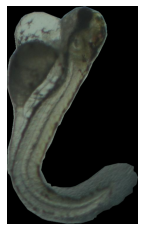

In [ ]:
import matplotlib.pyplot as plt

# Plot the image using matplotlib
plt.imshow(fish_body_processed[1])
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
def pad_and_resize_image(image, target_size=640):
    """
    Pad the image to make it square and then resize to the target size.
    
    Args:
        image (np.array): The input image (3 channels).
        target_size (int): The target size for the square image.
        
    Returns:
        np.array: The padded and resized square image.
    """
    height, width, _ = image.shape
    
    # Determine the padding needed to make the image square
    if height > width:
        pad_left = (height - width) // 2
        pad_right = height - width - pad_left
        padded_image = np.pad(image, ((0, 0), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
    elif width > height:
        pad_top = (width - height) // 2
        pad_bottom = width - height - pad_top
        padded_image = np.pad(image, ((pad_top, pad_bottom), (0, 0), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = image
    
    # Resize the padded image to the target size
    resized_image = np.array(Image.fromarray(padded_image).resize((target_size, target_size)))
    
    return resized_image

# Apply the function to all images in fish_body_processed
padded_and_resized_images = [pad_and_resize_image(image) for image in fish_body_processed]

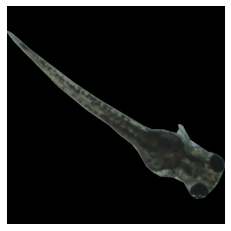

In [ ]:
import matplotlib.pyplot as plt

# Plot the image using matplotlib
plt.imshow(padded_and_resized_images[50])
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
labels = final_df["curved"].tolist()  # Convert the 'curved' column to a list of integers
print(len(padded_and_resized_images))
print(len(labels))

82
82


In [ ]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    padded_and_resized_images, labels, 
    test_size=0.3, 
    stratify=labels, 
    random_state=42
)

# Second split: 10% validation and 20% test from the remaining 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=2/3,  # 20% is 2/3 of 30%
    stratify=y_temp, 
    random_state=42
)

# Output the sizes
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 57
Validation set size: 8
Test set size: 17


In [ ]:
padded_and_resized_images=X_test
labels=y_test

In [ ]:
print(len(padded_and_resized_images))

17


In [ ]:
# Create empty lists for each label group
images_1 = []
images_2 = []
images_3 = []
images_4 = []

# Iterate over the images and labels
for image, label in zip(padded_and_resized_images, labels):
    if label == 1:
        images_1.append(image)
    elif label == 2:
        images_2.append(image)
    elif label == 3:
        images_3.append(image)
    elif label == 4:
        images_4.append(image)

# Now, images_1, images_2, images_3, and images_4 contain the respective images.


In [ ]:
print(len(images_1))

1


In [ ]:
from PIL import Image
import numpy as np

# Create a new list to hold the augmented dataset
augmented_images_1 = []

# Loop through each image in images_1
for image in images_1:
    # Convert the NumPy array to a PIL Image for transformations
    pil_image = Image.fromarray(image)

    # Original image
    augmented_images_1.append(image)

    # Horizontally flipped
    horizontal_flip = np.array(pil_image.transpose(Image.FLIP_LEFT_RIGHT))
    augmented_images_1.append(horizontal_flip)

    # Vertically flipped
    vertical_flip = np.array(pil_image.transpose(Image.FLIP_TOP_BOTTOM))
    augmented_images_1.append(vertical_flip)

    # Both horizontally and vertically flipped
    both_flipped = np.array(pil_image.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.FLIP_TOP_BOTTOM))
    augmented_images_1.append(both_flipped)

# Now augmented_images_1 contains the original images and the augmented ones
# The total size should be 4 times the original size of images_1
print(f"Original dataset size: {len(images_1)}")
print(f"Augmented dataset size: {len(augmented_images_1)}")


Original dataset size: 1
Augmented dataset size: 4


In [ ]:
from PIL import Image
import numpy as np

# Create a new list to hold the augmented dataset
augmented_images_2 = []

# Loop through each image in images_1
for image in images_2:
    # Convert the NumPy array to a PIL Image for transformations
    pil_image = Image.fromarray(image)

    # Original image
    augmented_images_2.append(image)

    # Horizontally flipped
    horizontal_flip = np.array(pil_image.transpose(Image.FLIP_LEFT_RIGHT))
    augmented_images_2.append(horizontal_flip)

    # Vertically flipped
    vertical_flip = np.array(pil_image.transpose(Image.FLIP_TOP_BOTTOM))
    augmented_images_2.append(vertical_flip)

# Now augmented_images_1 contains the original images and the augmented ones
# The total size should be 3 times the original size of images_1
print(f"Original dataset size: {len(images_2)}")
print(f"Augmented dataset size: {len(augmented_images_2)}")

Original dataset size: 3
Augmented dataset size: 9


In [ ]:
from PIL import Image
import numpy as np

# Create a new list to hold the augmented dataset
augmented_images_3 = []

# Loop through each image in images_1
for image in images_3:
    # Convert the NumPy array to a PIL Image for transformations
    pil_image = Image.fromarray(image)

    # Original image
    augmented_images_3.append(image)

    # Horizontally flipped
    horizontal_flip = np.array(pil_image.transpose(Image.FLIP_LEFT_RIGHT))
    augmented_images_3.append(horizontal_flip)


# Now augmented_images_1 contains the original images and the augmented ones
# The total size should be 2 times the original size of images_1
print(f"Original dataset size: {len(images_3)}")
print(f"Augmented dataset size: {len(augmented_images_3)}")


Original dataset size: 5
Augmented dataset size: 10


In [ ]:
from PIL import Image

# Create a list to hold the zoomed-out images
zoomed_1_images = []

# Define a function to zoom out by a given factor
def zoom_out_image(image, zoom_factor=0.2):
    """
    Zoom out the image by adding padding around it.
    
    Args:
        image (np.array): The input image (numpy array).
        zoom_factor (float): The percentage to extend the dimensions (0.2 = 20%).
    
    Returns:
        np.array: The zoomed-out image padded and resized to the original size.
    """
    pil_image = Image.fromarray(image)
    width, height = pil_image.size

    # Calculate padding size
    pad_width = int(width * zoom_factor)
    pad_height = int(height * zoom_factor)

    # Add padding around the image
    padded_image = Image.new("RGB", (width + 2 * pad_width, height + 2 * pad_height), (0, 0, 0))
    padded_image.paste(pil_image, (pad_width, pad_height))

    # Resize the padded image back to the original dimensions
    zoomed_out_image = padded_image.resize((width, height), Image.ANTIALIAS)

    return np.array(zoomed_out_image)

# Apply zooming out to every second image in augmented_images_1
for i, image in enumerate(augmented_images_1):
    if i % 2 == 1:  # Every second image
        zoomed_1_images.append(zoom_out_image(image))


# Append the zoomed-out images to the augmented_images_1 list
augmented_images_1.extend(zoomed_1_images)
# Now zoomed_1_images contains the zoomed-out versions of every second image
print(f"Total 1 images: {len(augmented_images_1)}")


Total 1 images: 6


<ipython-input-158-a3ce113cafce>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  zoomed_out_image = padded_image.resize((width, height), Image.ANTIALIAS)


In [ ]:
print(f"Number of images in augmented_images_1: {len(augmented_images_1)}")
print(f"Number of images in augmented_images_2: {len(augmented_images_2)}")
print(f"Number of images in augmented_images_3: {len(augmented_images_3)}")
print(f"Number of images in images_4: {len(images_4)}")

Number of images in augmented_images_1: 6
Number of images in augmented_images_2: 9
Number of images in augmented_images_3: 10
Number of images in images_4: 8


In [ ]:
import os
from PIL import Image

# Define the base directory to save the dataset
base_directory = "Zebra_fish_data/Balanced_dataset/test"

# Ensure the base directory exists
os.makedirs(base_directory, exist_ok=True)

# Define subdirectories for each label
subfolders = {
    1: "images_1",
    2: "images_2",
    3: "images_3",
    4: "images_4"
}

# Create subfolders for each label
for label, folder_name in subfolders.items():
    os.makedirs(os.path.join(base_directory, folder_name), exist_ok=True)

# Save images to their respective subfolders
def save_images(image_list, label):
    folder_path = os.path.join(base_directory, subfolders[label])
    for idx, image_array in enumerate(image_list):
        image = Image.fromarray(image_array.astype('uint8'))  # Convert numpy array to image
        image.save(os.path.join(folder_path, f"image_{idx + 1}.png"))  # Save as PNG

# Save each augmented image list to the respective folder
save_images(augmented_images_1, label=1)
save_images(augmented_images_2, label=2)
save_images(augmented_images_3, label=3)
save_images(images_4, label=4)

print("Data saved")


Data saved
